# Problem 1

### Part A

In [3]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

# load data 
digits = load_digits()
X = digits.data
y = (digits.target >= 5).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None

    def fit(self, X, y, sample_weights):
        n_samples, n_features = X.shape
        min_error = float('inf')
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = self._predict(X[:, feature], threshold, polarity)
                    error = np.sum(sample_weights * (predictions != y))
                    if error < min_error:
                        min_error = error
                        self.feature_index = feature
                        self.threshold = threshold
                        self.polarity = polarity

    def _predict(self, X_column, threshold, polarity):
        predictions = np.ones(X_column.shape)
        if polarity == 1:
            predictions[X_column < threshold] = 0
        else:
            predictions[X_column >= threshold] = 0
        return predictions

    def predict(self, X):
        return self._predict(X[:, self.feature_index], self.threshold, self.polarity)

class AdaBoost:
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.stumps = []
        self.alphas = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        sample_weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            stump.fit(X, y, sample_weights)
            predictions = stump.predict(X)
            error = np.sum(sample_weights * (predictions != y))

            if error > 0.5:
                continue
            stump.alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            sample_weights *= np.exp(-stump.alpha * y * (2 * predictions - 1))
            sample_weights /= np.sum(sample_weights)

            self.stumps.append(stump)
            self.alphas.append(stump.alpha)

    def predict(self, X):
        stump_preds = np.array([stump.alpha * stump.predict(X) for stump in self.stumps])
        return (np.sum(stump_preds, axis=0) > 0).astype(int)

# fit and predict AdaBoost
n_estimators = 50
custom_adaboost = AdaBoost(n_estimators=n_estimators)
custom_adaboost.fit(X_train, y_train)
custom_preds = custom_adaboost.predict(X_test)

# fit and predict AdaBoost using sklearn
sklearn_adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1), 
    n_estimators=n_estimators, 
    random_state=42
)
sklearn_adaboost.fit(X_train, y_train)
sklearn_preds = sklearn_adaboost.predict(X_test)

print("Custom AdaBoost Accuracy:", accuracy_score(y_test, custom_preds))
print("Custom AdaBoost F1 Score:", f1_score(y_test, custom_preds))
print("Sklearn AdaBoost Accuracy:", accuracy_score(y_test, sklearn_preds))
print("Sklearn AdaBoost F1 Score:", f1_score(y_test, sklearn_preds))


Custom AdaBoost Accuracy: 0.5166666666666667
Custom AdaBoost F1 Score: 0.6813186813186813
Sklearn AdaBoost Accuracy: 0.8916666666666667
Sklearn AdaBoost F1 Score: 0.8937329700272479


/home/connor/anaconda3/envs/comp_vis/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# Problem 2

### Part A: (iii) General Boosting Implementation

In [5]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# load data
digits = load_digits()
X = digits.data
y = (digits.target >= 5).astype(int) * 2 - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class LogisticBoosting:
    def __init__(self, n_estimators, step_size):
        self.n_estimators = n_estimators
        self.step_size = step_size
        self.models = []
        self.coefficients = []

    def fit(self, X, y):
        f = np.zeros(len(y))
        for _ in range(self.n_estimators):

            # weights
            residuals = -y / (1 + np.exp(y * f))
            weights = np.abs(residuals)

            # weak learner
            stump = DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=weights)

            # predict coefficient
            predictions = stump.predict(X)
            coefficient = np.dot(weights, y * predictions) / np.sum(weights)

            # update model
            f += self.step_size * coefficient * predictions
            self.models.append(stump)
            self.coefficients.append(coefficient)

    def predict(self, X):
        f = np.zeros(X.shape[0])
        for model, coeff in zip(self.models, self.coefficients):
            f += self.step_size * coeff * model.predict(X)
        return np.sign(f)

# train logistic boosting
logistic_boost = LogisticBoosting(n_estimators=50, step_size=0.1)
logistic_boost.fit(X_train, y_train)
logistic_preds = logistic_boost.predict(X_test)

print("Logistic Boosting Accuracy:", accuracy_score(y_test, logistic_preds))
print("Logistic Boosting F1 Score:", f1_score(y_test, logistic_preds))

# compare with AdaBoost
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50)
adaboost.fit(X_train, y_train)
adaboost_preds = adaboost.predict(X_test)

print("AdaBoost Accuracy:", accuracy_score(y_test, adaboost_preds))
print("AdaBoost F1 Score:", f1_score(y_test, adaboost_preds))

Logistic Boosting Accuracy: 0.8
Logistic Boosting F1 Score: 0.8032786885245902
AdaBoost Accuracy: 0.8916666666666667
AdaBoost F1 Score: 0.8937329700272479


/home/connor/anaconda3/envs/comp_vis/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Part B

In [6]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# load data
data = fetch_california_housing()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class BoostedCART:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        f = np.full(len(y), np.mean(y))
        self.initial_prediction = np.mean(y)

        for _ in range(self.n_estimators):
            # get residuals
            residuals = y - f

            # fit a CART regressor to the residuals
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residuals)

            # update the model
            predictions = model.predict(X)
            f += self.learning_rate * predictions

            # save weak learner
            self.models.append(model)

    def predict(self, X):
        f = np.full(X.shape[0], self.initial_prediction)

        # add contributions from all weak learners
        for model in self.models:
            f += self.learning_rate * model.predict(X)

        return f

# train
boosted_cart = BoostedCART(n_estimators=100, learning_rate=0.1, max_depth=3)
boosted_cart.fit(X_train, y_train)
y_pred_custom = boosted_cart.predict(X_test)

# evaluate
mse_custom = mean_squared_error(y_test, y_pred_custom)
r2_custom = r2_score(y_test, y_pred_custom)

print("Custom Boosted CART MSE:", mse_custom)
print("Custom Boosted CART R^2:", r2_custom)

# scikit-learn's GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred_sklearn = gbr.predict(X_test)

# sklearn GradientBoostingRegressor
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
r2_sklearn = r2_score(y_test, y_pred_sklearn)

print("Sklearn GradientBoostingRegressor MSE:", mse_sklearn)
print("Sklearn GradientBoostingRegressor R^2:", r2_sklearn)


Custom Boosted CART MSE: 0.2940161448268125
Custom Boosted CART R^2: 0.7756302423831822
Sklearn GradientBoostingRegressor MSE: 0.2939973248643864
Sklearn GradientBoostingRegressor R^2: 0.7756446042829697


# Problem 3

### Part A

Mean Squared Error: 0.26


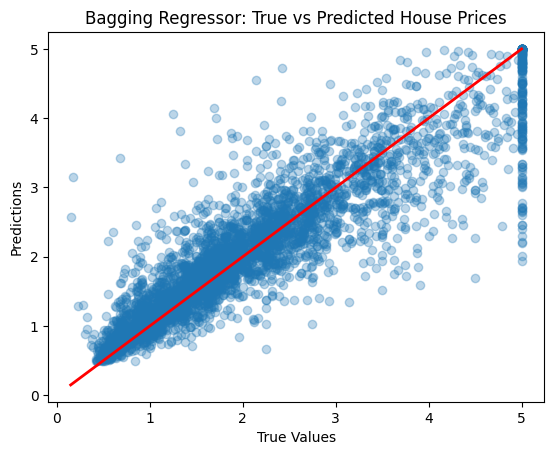

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# init data
data = fetch_california_housing()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_regressor = DecisionTreeRegressor(random_state=42)
bagging_model = BaggingRegressor(estimator=base_regressor, n_estimators=100, random_state=42)

# train and predict
bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# actual vs predicted house prices
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Bagging Regressor: True vs Predicted House Prices')
plt.show()

### Part B

Mean Squared Error: 0.25


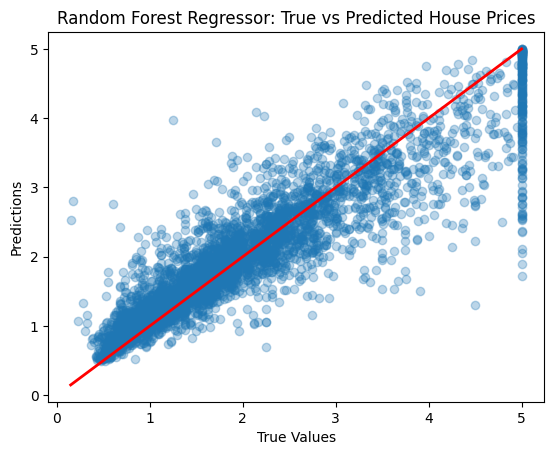

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# data initialization
data = fetch_california_housing()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)

# training and prediction
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# actual vs predicted house prices
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest Regressor: True vs Predicted House Prices')
plt.show()


### Part C

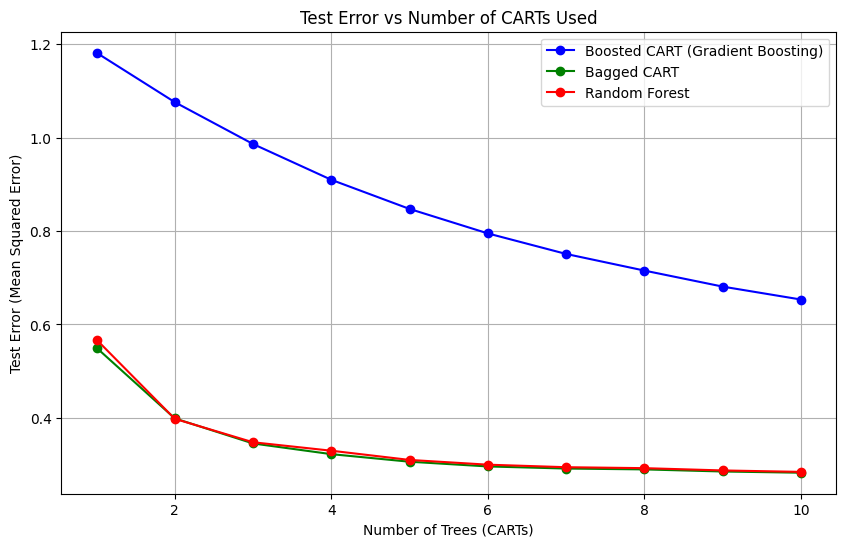

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# initialize data
data = fetch_california_housing()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_counts = np.arange(1, 11)
boosted_mse = []
bagged_mse = []
rf_mse = []

# boosted CART using GradientBoostingRegressor
for n_trees in tree_counts:
    boosted_model = GradientBoostingRegressor(n_estimators=n_trees, random_state=42)
    boosted_model.fit(X_train, y_train)
    y_pred = boosted_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    boosted_mse.append(mse)

# bagged CART using BaggingRegressor with DecisionTreeRegressor as estimator
for n_trees in tree_counts:
    bagged_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=n_trees, random_state=42)
    bagged_model.fit(X_train, y_train)
    y_pred = bagged_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    bagged_mse.append(mse)

# Random Forests
for n_trees in tree_counts:
    rf_model = RandomForestRegressor(n_estimators=n_trees, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rf_mse.append(mse)

# visualize results
plt.figure(figsize=(10, 6))
plt.plot(tree_counts, boosted_mse, label='Boosted CART (Gradient Boosting)', marker='o', linestyle='-', color='blue')
plt.plot(tree_counts, bagged_mse, label='Bagged CART', marker='o', linestyle='-', color='green')
plt.plot(tree_counts, rf_mse, label='Random Forest', marker='o', linestyle='-', color='red')

plt.xlabel('Number of Trees (CARTs)')
plt.ylabel('Test Error (Mean Squared Error)')
plt.title('Test Error vs Number of CARTs Used')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()